In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import scipy
import os
import time

In [2]:
# Helper function to calculate the angle between three points.
def calculate_angle(a, b, c):
    """
    Calculates the angle (in degrees) between the line segments ab and bc.
    
    Args:
        a, b, c (list or array): [x, y] coordinates.

    Returns:
        float: The calculated angle in degrees.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    ba = a - b
    bc = c - b
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

# Determine which arm to use based on the z-coordinates of the shoulders.
def determine_arm(frame, pose_model):
    """
    Determines which arm to use for analysis (left or right) by comparing
    the z-coordinates of the left and right shoulders.
    
    Args:
        frame (numpy.ndarray): A single video frame in BGR format.
        pose_model: An instance of the Mediapipe Pose model.
    
    Returns:
        bool: True if the right arm should be used, False for the left.
    """
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose_model.process(image_rgb)
    use_right_arm = True  # Default to right

    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        if landmarks[mp.solutions.pose.PoseLandmark.LEFT_SHOULDER].z < \
           landmarks[mp.solutions.pose.PoseLandmark.RIGHT_SHOULDER].z:
            use_right_arm = False

    return use_right_arm

# Process video frames and extract the elbow angles along with timestamps 
# and annotated frames.
def process_video_frames(video_path):
    """
    Processes video frames to extract the elbow angle using Mediapipe.
    
    Args:
        video_path (str): Path to the input video.
    
    Returns:
        timestamps (np.array): Array of time stamps.
        angles (np.array): Array of computed elbow angles.
        annotated_frames (list): List of tuples (timestamp, frame) after drawing.
        fps (int): Frames per second in the input video.
        frame_width (int): Width of the video frames.
        frame_height (int): Height of the video frames.
    """
    mp_pose = mp.solutions.pose
    pose_model = mp_pose.Pose()

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Read the first frame to decide which arm to track.
    ret, first_frame = cap.read()
    if not ret:
        cap.release()
        pose_model.close()
        raise ValueError("Unable to read video frame")

    use_right_arm = determine_arm(first_frame, pose_model)
    shoulder_landmark = (mp_pose.PoseLandmark.RIGHT_SHOULDER if use_right_arm 
                         else mp_pose.PoseLandmark.LEFT_SHOULDER)
    elbow_landmark = (mp_pose.PoseLandmark.RIGHT_ELBOW if use_right_arm 
                      else mp_pose.PoseLandmark.LEFT_ELBOW)
    wrist_landmark = (mp_pose.PoseLandmark.RIGHT_WRIST if use_right_arm 
                      else mp_pose.PoseLandmark.LEFT_WRIST)
    
    # Reset to the beginning of the video.
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    angles = []
    timestamps = []
    annotated_frames = []
    frame_idx = 0
    print("Processing video frames...")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_idx += 1
        timestamp = frame_idx / fps
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose_model.process(image_rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            
            shoulder = [landmarks[shoulder_landmark.value].x * frame_width,
                        landmarks[shoulder_landmark.value].y * frame_height]
            elbow = [landmarks[elbow_landmark.value].x * frame_width,
                     landmarks[elbow_landmark.value].y * frame_height]
            wrist = [landmarks[wrist_landmark.value].x * frame_width,
                     landmarks[wrist_landmark.value].y * frame_height]
            
            angle = calculate_angle(shoulder, elbow, wrist)
            angles.append(angle)
            timestamps.append(timestamp)
            
            # Draw keypoints.
            cv2.circle(frame, tuple(map(int, shoulder)), 8, (0, 255, 0), -1)
            cv2.circle(frame, tuple(map(int, elbow)), 8, (255, 0, 0), -1)
            cv2.circle(frame, tuple(map(int, wrist)), 8, (0, 0, 255), -1)
            
            # Draw connecting lines.
            cv2.line(frame, tuple(map(int, shoulder)),
                     tuple(map(int, elbow)), (255, 255, 255), 2)
            cv2.line(frame, tuple(map(int, elbow)),
                     tuple(map(int, wrist)), (255, 255, 255), 2)
            
            # Display the elbow angle.
            cv2.putText(frame, f"Angle: {int(angle)} deg", 
                        (int(elbow[0]) + 20, int(elbow[1]) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        annotated_frames.append((timestamp, frame))
        print(f"\rProgress: {(frame_idx/total_frames)*100:.1f}%", end="")

    print("\n")
    cap.release()
    pose_model.close()

    return np.array(timestamps), np.array(angles), annotated_frames, fps, frame_width, frame_height


from scipy.signal import find_peaks

def detect_reps(angles, timestamps, sigma=10, min_distance=50, min_valley_diff=60):
    """
    Detects bicep curl repetitions by identifying peaks (high points) and valleys
    (low points) dynamically.

    Args:
        angles (list or np.array): The elbow angles over time.
        timestamps (list or np.array): The corresponding timestamps.
        sigma (float): Smoothing factor for the angles.
        min_distance (int): Minimum distance between peaks/valleys (in samples).
        min_valley_diff (int): Minimum angle difference required between peak and valley.

    Returns:
        rep_segments (list): List of tuples (start_time, end_time) for each rep.
        angles_smoothed (np.array): The smoothed angle data.
    """
    # Smooth the angles to reduce noise
    angles_smoothed = scipy.ndimage.gaussian_filter1d(angles, sigma=sigma)
    
    # Find peaks (local maxima) and valleys (local minima)
    peaks, _ = find_peaks(angles_smoothed, distance=min_distance, height=90)  # Only peaks above 90 degrees
    valleys, _ = find_peaks(-angles_smoothed, distance=min_distance, height=(-90))  # Inverted signal for valleys, must be below 90
    
    # Validate peaks and valleys
    valid_peaks = []
    valid_valleys = []
    for i in range(len(peaks)-1):
        # Find valleys between consecutive peaks
        valley_candidates = [v for v in valleys if peaks[i] < v < peaks[i+1]]
        
        if valley_candidates:
            # If multiple valleys exist, keep only the one with highest angle (shallowest valley)
            valley = max(valley_candidates, key=lambda v: angles_smoothed[v])
            
            # Check if valley is deep enough compared to both peaks
            peak1_to_valley = angles_smoothed[peaks[i]] - angles_smoothed[valley]
            valley_to_peak2 = angles_smoothed[peaks[i+1]] - angles_smoothed[valley]
            
            if peak1_to_valley >= min_valley_diff and valley_to_peak2 >= min_valley_diff:
                valid_peaks.append(peaks[i])
                valid_valleys.append(valley)
                if i == len(peaks)-2:  # Add the last peak if its valley was valid
                    valid_peaks.append(peaks[i+1])
    
    # Create rep segments from valid peaks
    rep_segments = []
    if valid_peaks:
        # First segment starts from beginning to first valid peak
        rep_segments.append((timestamps[0], timestamps[valid_peaks[0]]))
        
        # Middle segments
        for i in range(len(valid_peaks)-1):
            rep_segments.append((timestamps[valid_peaks[i]], timestamps[valid_peaks[i+1]]))
            
        # Last segment from last valid peak to end
        rep_segments.append((timestamps[valid_peaks[-1]], timestamps[-1]))

    return rep_segments

# Plot the elbow angle versus time and mark the detected repetitions.
def plot_elbow_angle(timestamps, angles_smoothed, rep_segments, file_name):
    """
    Plots the smoothed elbow angle over time and highlights the periods
    considered as repetitions.

    Args:
        timestamps (np.array): Array of timestamps.
        angles_smoothed (np.array): Smoothed elbow angle values.
        rep_segments (list): List of rep segments as (start_time, end_time).
    """
    plt.figure(figsize=(15, 5))
    plt.plot(timestamps, angles_smoothed, 'b-', label='Elbow Angle')
    
    colors=['green', 'red']
    
    # Highlight the periods considered as repetitions
    for i, (start, end) in enumerate(rep_segments):
        plt.axvspan(start, end, color=colors[i % len(colors)], alpha=0.3, label='Rep Period')
    
    # Add labels and legend
    plt.xlabel('Time (seconds)')
    plt.ylabel('Elbow Angle (degrees)')
    plt.title(f'Bicep Curl Analysis - {file_name}')
    plt.legend(['Elbow Angle', 'Rep Period'], loc='upper right')
    plt.grid(True)
    plt.gca().invert_yaxis()  # Reverse the y-axis
    plt.show()

# Overlay repetition markers on the annotated video frames.
def overlay_rep_markers(annotated_frames, rep_segments, fps):
    """
    Overlays rep start and end markers on each annotated frame.
    
    Args:
        annotated_frames (list): List of tuples (timestamp, frame).
        rep_segments (list): List of rep segments as (start_time, end_time).
        fps (int): Frames per second.
        
    Returns:
        List of frames with overlay annotations.
    """
    updated_frames = []
    for timestamp, frame in annotated_frames:
        # Find current rep
        current_rep = 0
        for i, (start, end) in enumerate(rep_segments):
            if start <= timestamp <= end:
                current_rep = i + 1
            if abs(timestamp - start) < 1 / fps:
                cv2.circle(frame, (50, 50), 15, (0, 255, 0), -1)
                cv2.putText(frame, f"Start Rep {i+1}", (70, 55),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            if abs(timestamp - end) < 1 / fps:
                cv2.circle(frame, (50, 100), 15, (0, 0, 255), -1)
                cv2.putText(frame, f"End Rep {i+1}", (70, 105),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
        # Draw stats overlay
        y_offset = 30
        cv2.putText(frame, f"Time: {timestamp:.1f}s", (10, y_offset),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        y_offset += 25
        cv2.putText(frame, f"Current Rep: {current_rep}", (10, y_offset),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        y_offset += 25
        cv2.putText(frame, f"Total Reps: {len(rep_segments)}", (10, y_offset),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        if current_rep > 0 and current_rep <= len(rep_segments):
            start, end = rep_segments[current_rep-1]
            y_offset += 25
            cv2.putText(frame, f"Rep Duration: {end-start:.1f}s", (10, y_offset),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            
        updated_frames.append(frame)
    return updated_frames

# Write the annotated frames to a video file.
def write_video(frames, output_path, fps, frame_width, frame_height):
    """
    Writes a list of frames to a video file.
    
    Args:
        frames (list): List of frames (images).
        output_path (str): Path to save the output video.
        fps (int): Frames per second.
        frame_width (int): Width of video frames.
        frame_height (int): Height of video frames.
    """
    out = cv2.VideoWriter(
        output_path,
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (frame_width, frame_height)
    )
    for frame in frames:
        out.write(frame)
    out.release()
    print(f"✅ Processed video saved as `{output_path}`")

# Main routine that ties everything together.
def run_bicep_curl_analysis(video_path, output_path="bicep_curl_debug.mp4"):
    """
    Orchestrates the bicep curl analysis pipeline:
      1. Process video frames to extract angles.
      2. Detect reps via signal processing.
      3. Plot the elbow angle versus time.
      4. Overlay rep markers on the video.
      5. Write the annotated video to disk.
    
    Args:
        video_path (str): Path to the input video.
        output_path (str): Path to save the annotated output video.
    
    Returns:
        list: List of rep segments (each as (start_time, end_time)).
    """
    start_time = time.time()
    
    timestamps, angles, annotated_frames, fps, frame_width, frame_height = \
        process_video_frames(video_path)
    rep_segments = detect_reps(angles, timestamps)
    
    print("\nDetected reps:")
    for i, (start, end) in enumerate(rep_segments):
        print(f"Rep {i+1}: Start = {start:.2f}s, End = {end:.2f}s, "
              f"Duration = {end - start:.2f}s")
    
    plot_elbow_angle(timestamps, angles, rep_segments, video_path)
    frames_with_overlay = overlay_rep_markers(annotated_frames, rep_segments, fps)
    write_video(frames_with_overlay, output_path, fps, frame_width, frame_height)
    
    end_time = time.time()
    print(f"\nTotal processing time: {end_time - start_time:.2f} seconds")
    
    return rep_segments

In [17]:
# timestamps, angles, annotated_frames, fps, frame_width, frame_height = \
#         process_video_frames("./data/12r (1).mp4")
        
files = os.listdir("./data")
print(files)

# for each file in ./data folder, run the analyze_bicep_curls function
analysis_results = []        
for file in files:
    if file.endswith(".mp4"):
        print(f"Analyzing {file}")
        timestamps, angles, annotated_frames, fps, frame_width, frame_height = \
            process_video_frames("./data/" + file)
        analysis_results.append((file, timestamps, angles, fps, frame_width, frame_height))




['.DS_Store', '14r (1).mp4', '4_r.mp4', '12r (1).mp4', '13r (1).mp4', '5_r.mp4', '7_r (1).mp4', '5_l.mp4', '6_l.mp4', '8_r (1).mp4', '9r (1).mp4', '11r (1).mp4', '10r (1).mp4']
Analyzing 14r (1).mp4
Processing video frames...


I0000 00:00:1739642117.341526  361396 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739642117.419289  373823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739642117.434472  373823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 100.0%

Analyzing 4_r.mp4
Processing video frames...
Progress: 0.1%

I0000 00:00:1739642165.934528  361396 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739642166.048982  374564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739642166.064578  374570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 99.8%

Analyzing 12r (1).mp4
Processing video frames...
Progress: 0.0%

I0000 00:00:1739642198.537845  361396 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739642198.641838  375918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739642198.669989  375916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 100.0%

Analyzing 13r (1).mp4
Processing video frames...
Progress: 0.0%

I0000 00:00:1739642289.507824  361396 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739642289.618115  378908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739642289.635751  378910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 100.0%

Analyzing 5_r.mp4
Processing video frames...
Progress: 0.1%

I0000 00:00:1739642344.523518  361396 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739642344.618948  380359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739642344.644913  380364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 100.0%

Analyzing 7_r (1).mp4


I0000 00:00:1739642400.599603  361396 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739642400.709988  381925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739642400.779895  381928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing video frames...
Progress: 100.0%

Analyzing 5_l.mp4
Processing video frames...


I0000 00:00:1739642412.917822  361396 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739642413.007065  382156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739642413.021891  382156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 91.1%

Analyzing 6_l.mp4


I0000 00:00:1739642455.968593  361396 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739642456.042008  382900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739642456.052892  382898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing video frames...
Progress: 100.0%

Analyzing 8_r (1).mp4
Processing video frames...
Progress: 0.6%

I0000 00:00:1739642478.620771  361396 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739642478.706313  383476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739642478.718986  383476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 100.0%

Analyzing 9r (1).mp4
Processing video frames...
Progress: 0.2%

I0000 00:00:1739642489.764020  361396 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739642489.840356  383581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739642489.852797  383581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 100.0%

Analyzing 11r (1).mp4


I0000 00:00:1739642530.745016  361396 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739642530.819298  384592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739642530.830610  384592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processing video frames...
Progress: 100.0%

Analyzing 10r (1).mp4
Processing video frames...
Progress: 0.4%

I0000 00:00:1739642555.686662  361396 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739642555.768265  385283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739642555.781648  385283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 100.0%



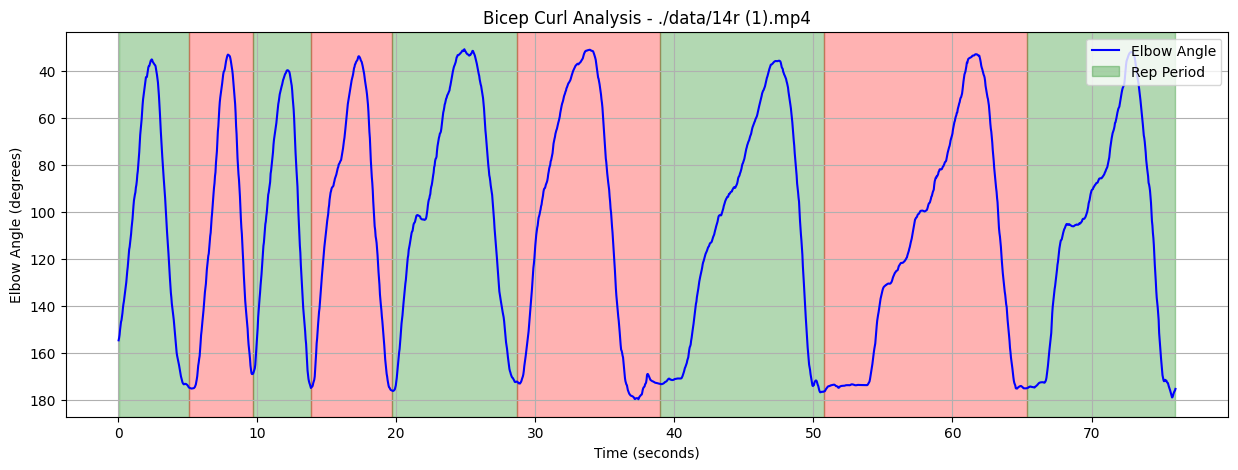

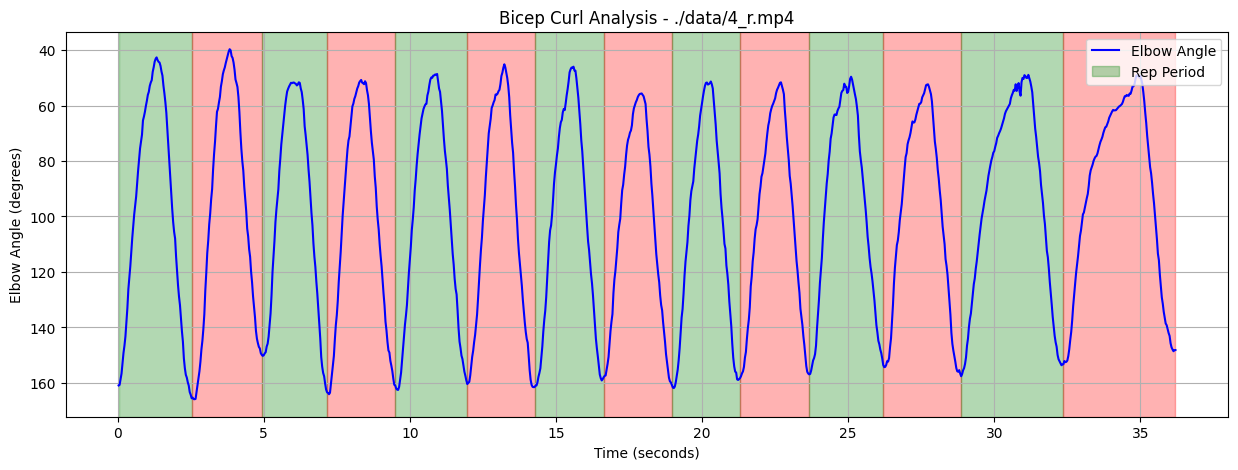

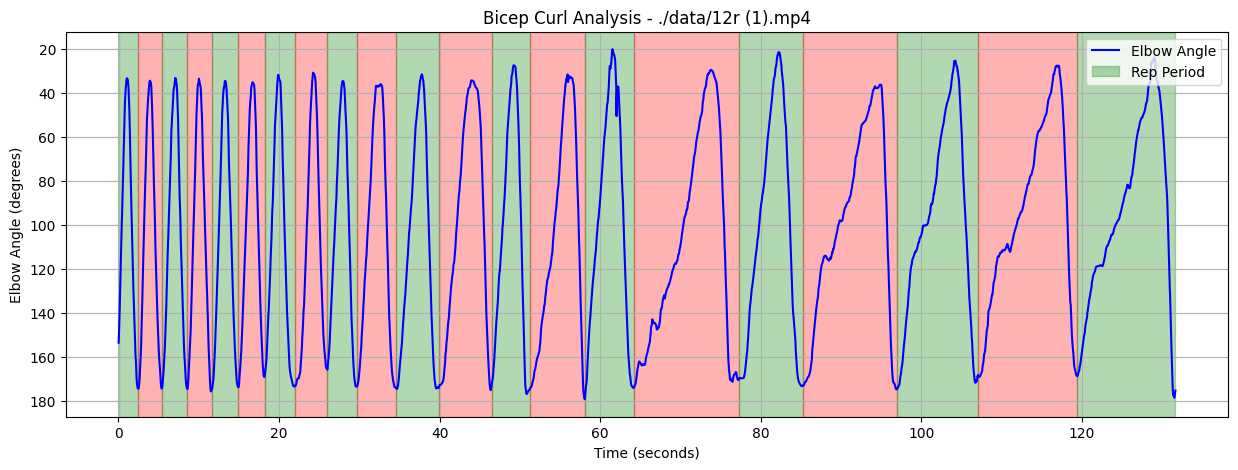

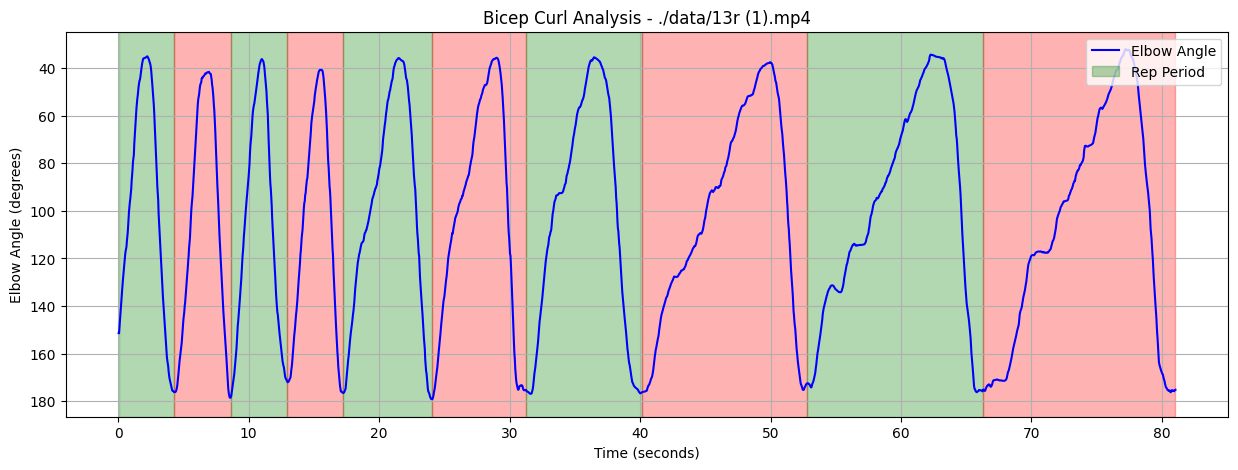

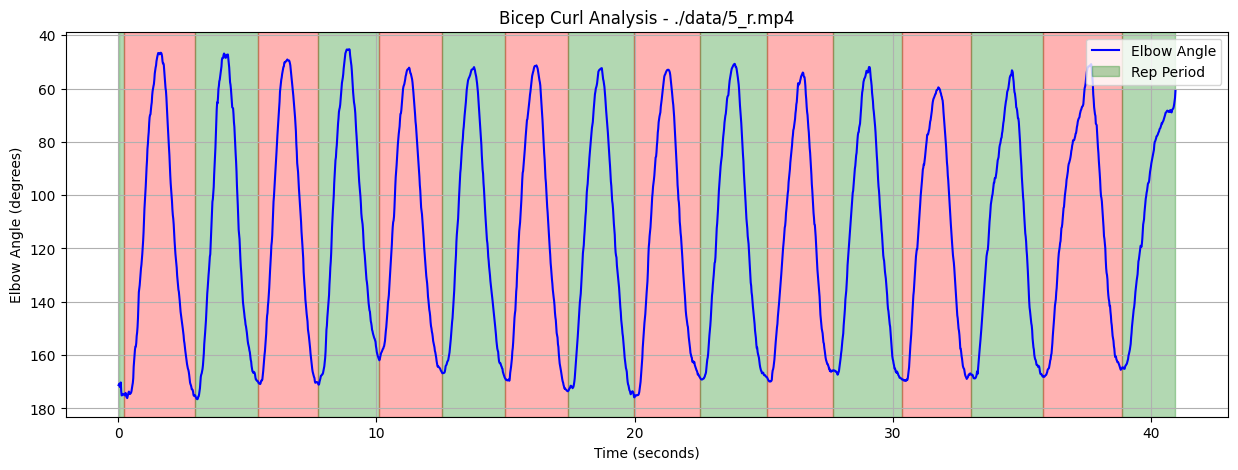

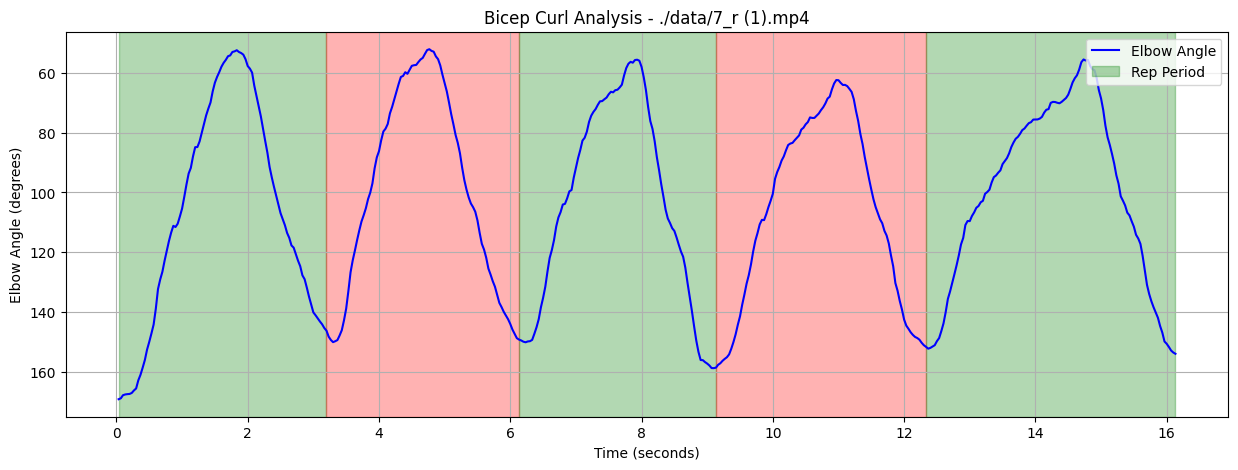

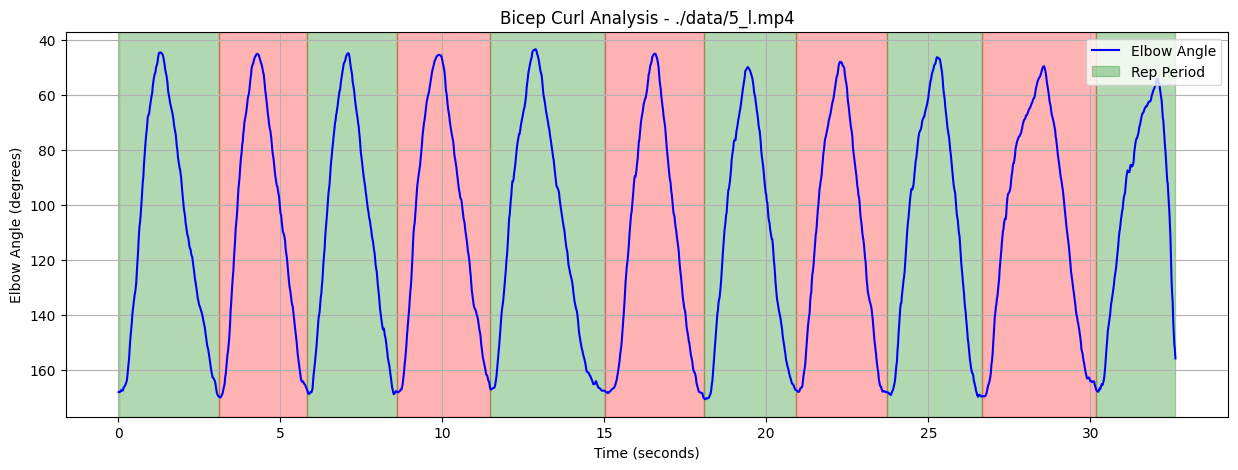

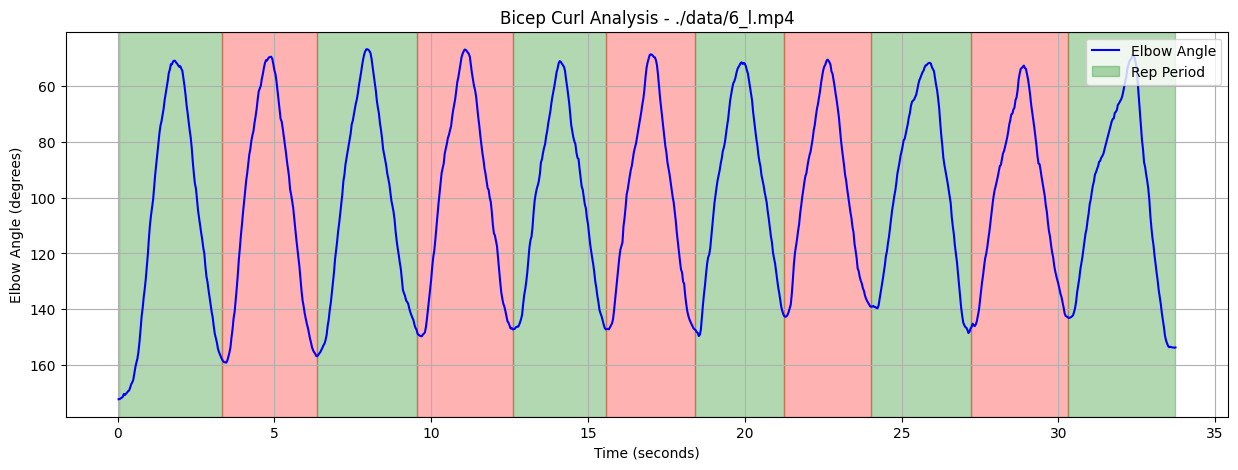

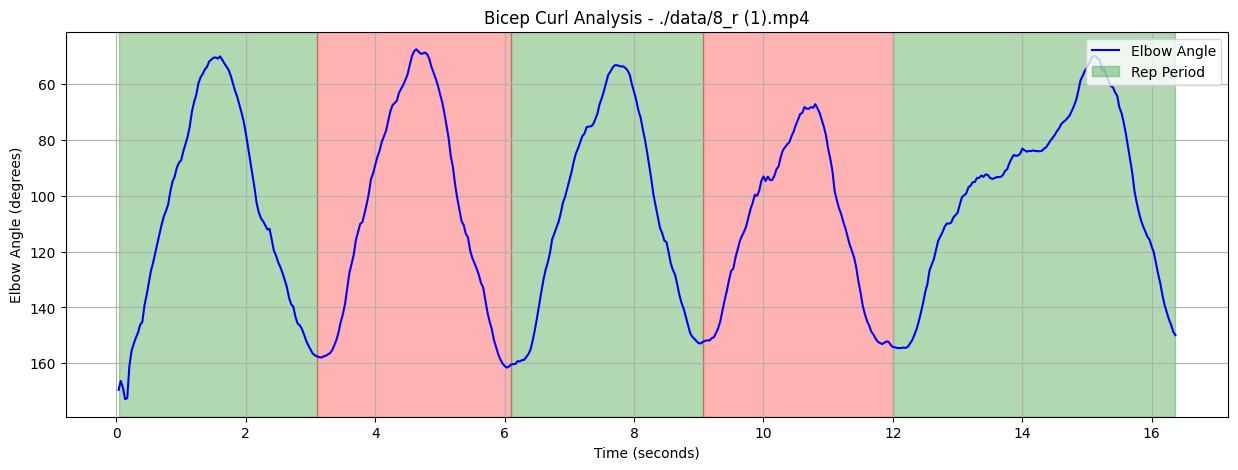

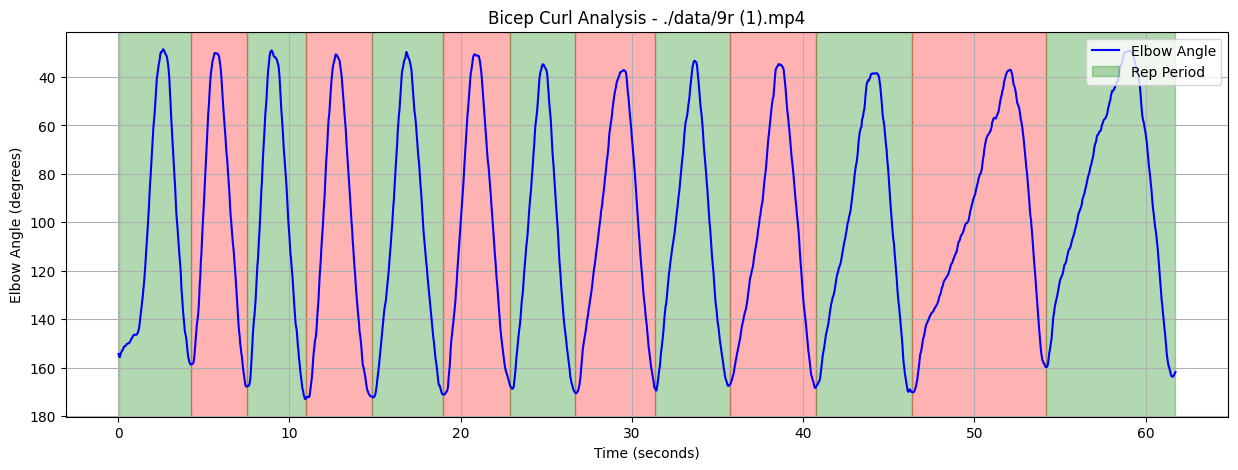

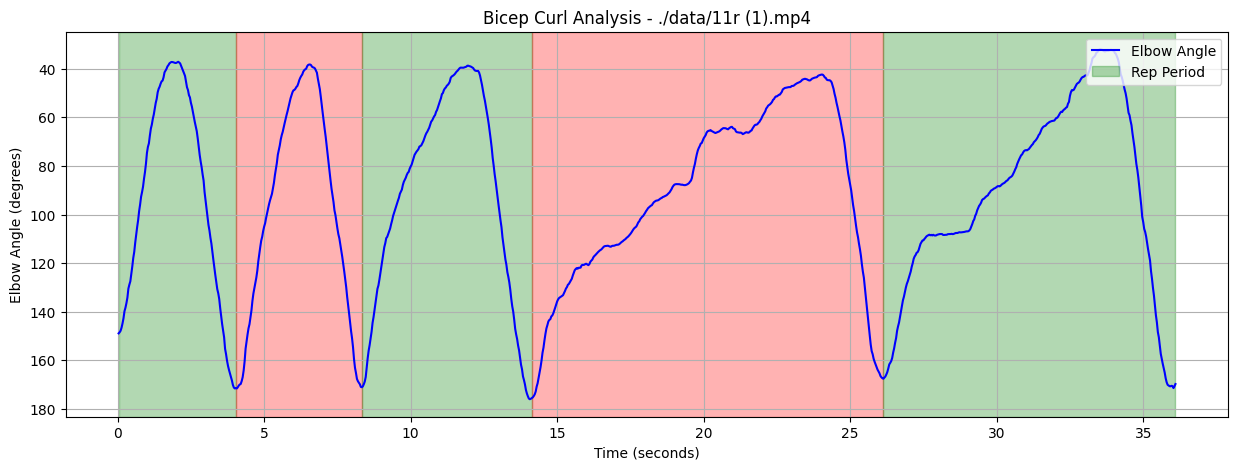

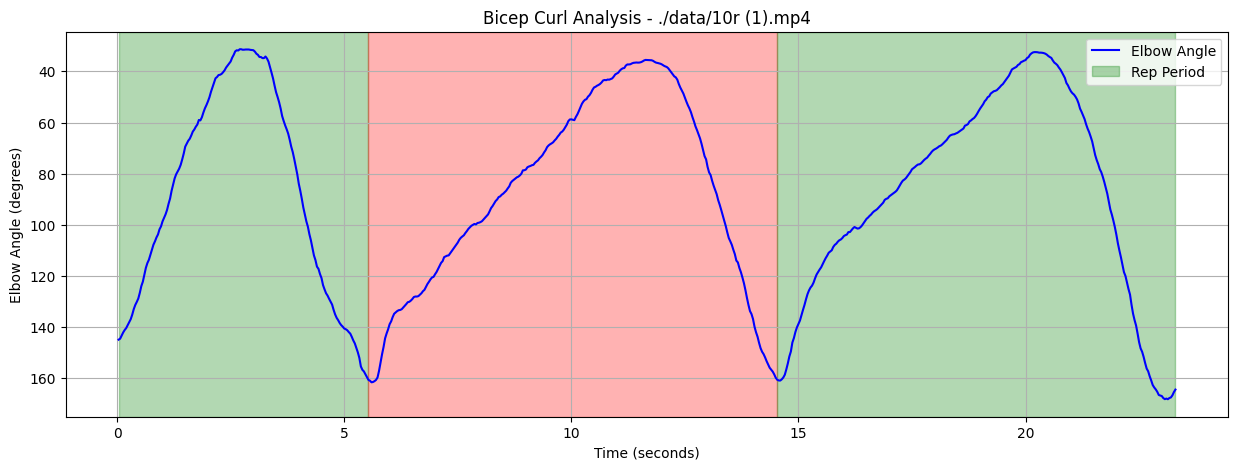

In [45]:
for file, timestamps, angles, fps, frame_width, frame_height in analysis_results:
    rep_segments = detect_reps(angles, timestamps)
    plot_elbow_angle(timestamps, angles, rep_segments, "./data/" + file)


['.DS_Store', '14r (1).mp4', '4_r.mp4', '12r (1).mp4', '13r (1).mp4', '5_r.mp4', '7_r (1).mp4', '5_l.mp4', 't2.mp4', 't3.mp4', 't1.mp4', '6_l.mp4', 't4.mp4', 't5.mp4', '8_r (1).mp4', '9r (1).mp4', '11r (1).mp4', '10r (1).mp4', 't6.mp4']
Analyzing t2.mp4


I0000 00:00:1739719117.402757  776320 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1739719117.521511  777619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739719117.536355  777619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739719117.553488  777618 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


Processing video frames...
Progress: 100.0%


Detected reps:
Rep 1: Start = 0.03s, End = 2.33s, Duration = 2.30s
Rep 2: Start = 2.33s, End = 4.87s, Duration = 2.53s
Rep 3: Start = 4.87s, End = 7.50s, Duration = 2.63s
Rep 4: Start = 7.50s, End = 9.90s, Duration = 2.40s
Rep 5: Start = 9.90s, End = 12.27s, Duration = 2.37s
Rep 6: Start = 12.27s, End = 14.63s, Duration = 2.37s
Rep 7: Start = 14.63s, End = 16.97s, Duration = 2.33s
Rep 8: Start = 16.97s, End = 19.17s, Duration = 2.20s
Rep 9: Start = 19.17s, End = 21.37s, Duration = 2.20s
Rep 10: Start = 21.37s, End = 23.57s, Duration = 2.20s
Rep 11: Start = 23.57s, End = 25.83s, Duration = 2.27s
Rep 12: Start = 25.83s, End = 28.20s, Duration = 2.37s
Rep 13: Start = 28.20s, End = 30.63s, Duration = 2.43s
Rep 14: Start = 30.63s, End = 33.30s, Duration = 2.67s
Rep 15: Start = 33.30s, End = 35.97s, Duration = 2.67s
Rep 16: Start = 35.97s, End = 38.80s, Duration = 2.83s
Rep 17: Start = 38.80s, End = 41.63s, Duration = 2.83s
Rep 18: Start = 41.63s

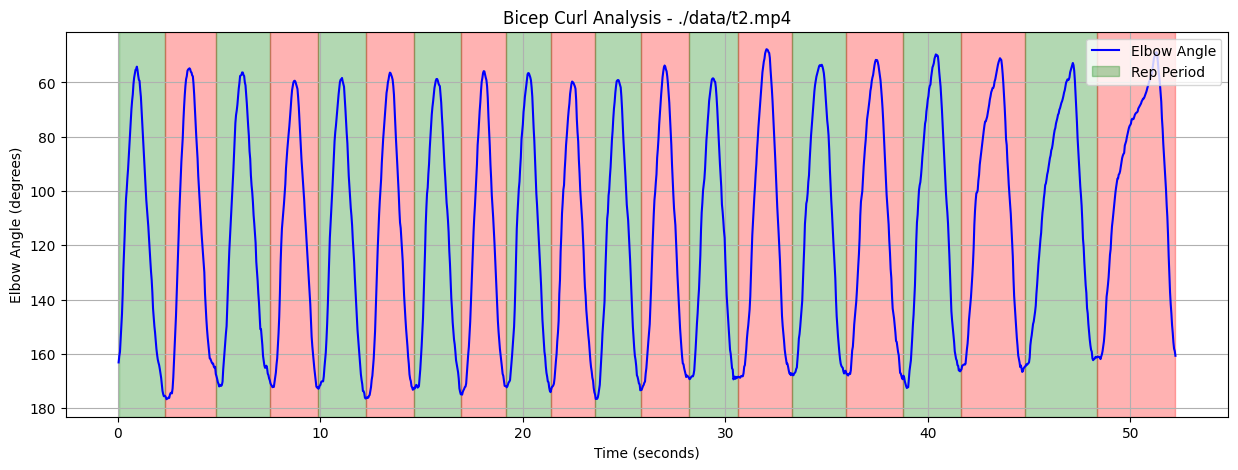

✅ Processed video saved as `./out/t2.mp4`

Total processing time: 38.35 seconds
Analyzing t3.mp4
Processing video frames...
Progress: 0.3%

I0000 00:00:1739719155.812692  776320 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739719155.891073  778296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739719155.902902  778296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 100.0%


Detected reps:
Rep 1: Start = 0.03s, End = 2.07s, Duration = 2.03s
Rep 2: Start = 2.07s, End = 4.47s, Duration = 2.40s
Rep 3: Start = 4.47s, End = 6.87s, Duration = 2.40s
Rep 4: Start = 6.87s, End = 9.47s, Duration = 2.60s
Rep 5: Start = 9.47s, End = 11.93s, Duration = 2.47s
Rep 6: Start = 11.93s, End = 14.40s, Duration = 2.47s
Rep 7: Start = 14.40s, End = 16.83s, Duration = 2.43s
Rep 8: Start = 16.83s, End = 19.20s, Duration = 2.37s
Rep 9: Start = 19.20s, End = 21.70s, Duration = 2.50s
Rep 10: Start = 21.70s, End = 24.37s, Duration = 2.67s
Rep 11: Start = 24.37s, End = 27.17s, Duration = 2.80s
Rep 12: Start = 27.17s, End = 30.77s, Duration = 3.60s


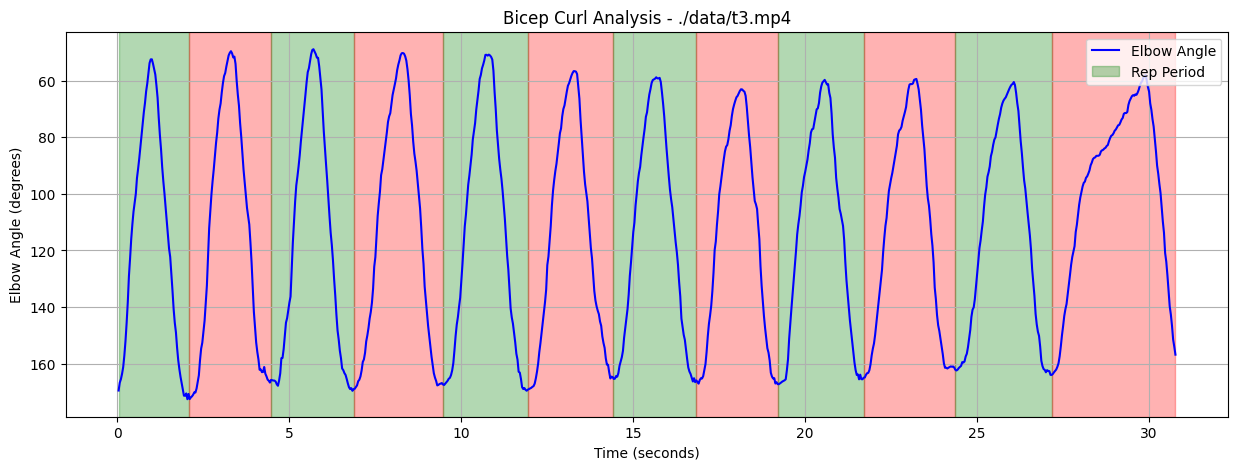

✅ Processed video saved as `./out/t3.mp4`

Total processing time: 21.92 seconds
Analyzing t1.mp4
Processing video frames...
Progress: 0.3%

I0000 00:00:1739719177.796843  776320 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739719177.873402  778689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739719177.885046  778689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 100.0%


Detected reps:
Rep 1: Start = 0.03s, End = 2.77s, Duration = 2.73s
Rep 2: Start = 2.77s, End = 5.57s, Duration = 2.80s
Rep 3: Start = 5.57s, End = 8.30s, Duration = 2.73s
Rep 4: Start = 8.30s, End = 10.97s, Duration = 2.67s
Rep 5: Start = 10.97s, End = 13.57s, Duration = 2.60s
Rep 6: Start = 13.57s, End = 16.27s, Duration = 2.70s
Rep 7: Start = 16.27s, End = 18.87s, Duration = 2.60s
Rep 8: Start = 18.87s, End = 21.73s, Duration = 2.87s
Rep 9: Start = 21.73s, End = 24.50s, Duration = 2.77s
Rep 10: Start = 24.50s, End = 27.93s, Duration = 3.43s
Rep 11: Start = 27.93s, End = 31.83s, Duration = 3.90s


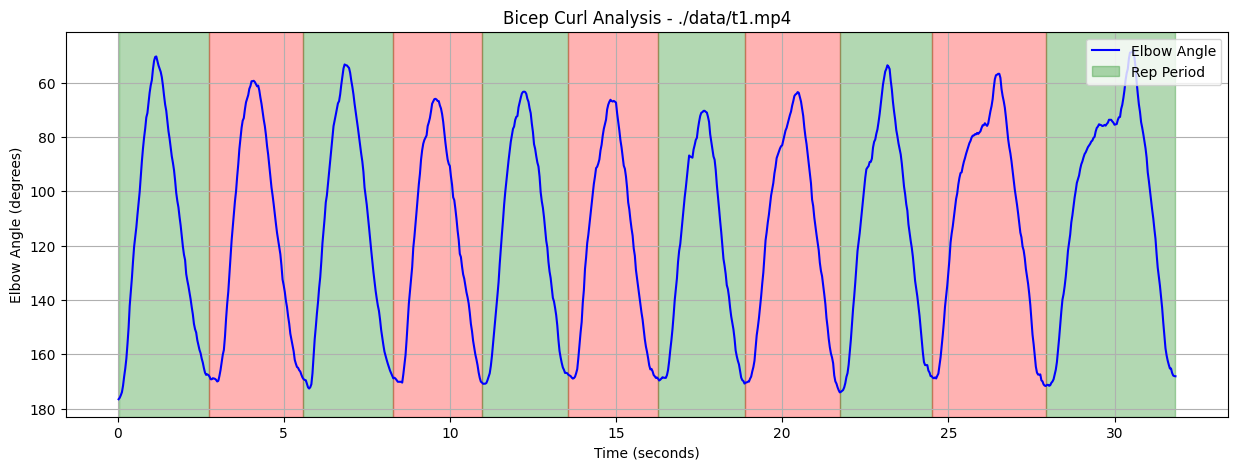

✅ Processed video saved as `./out/t1.mp4`

Total processing time: 23.59 seconds
Analyzing t4.mp4
Processing video frames...
Progress: 0.2%

I0000 00:00:1739719201.477272  776320 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739719201.554802  779051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739719201.565992  779051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 100.0%


Detected reps:
Rep 1: Start = 0.03s, End = 2.07s, Duration = 2.03s
Rep 2: Start = 2.07s, End = 4.33s, Duration = 2.27s
Rep 3: Start = 4.33s, End = 6.73s, Duration = 2.40s
Rep 4: Start = 6.73s, End = 9.07s, Duration = 2.33s
Rep 5: Start = 9.07s, End = 11.40s, Duration = 2.33s
Rep 6: Start = 11.40s, End = 13.73s, Duration = 2.33s
Rep 7: Start = 13.73s, End = 16.20s, Duration = 2.47s
Rep 8: Start = 16.20s, End = 18.83s, Duration = 2.63s
Rep 9: Start = 18.83s, End = 21.53s, Duration = 2.70s
Rep 10: Start = 21.53s, End = 24.10s, Duration = 2.57s
Rep 11: Start = 24.10s, End = 26.80s, Duration = 2.70s
Rep 12: Start = 26.80s, End = 29.53s, Duration = 2.73s
Rep 13: Start = 29.53s, End = 32.23s, Duration = 2.70s
Rep 14: Start = 32.23s, End = 35.07s, Duration = 2.83s
Rep 15: Start = 35.07s, End = 38.17s, Duration = 3.10s
Rep 16: Start = 38.17s, End = 41.73s, Duration = 3.57s
Rep 17: Start = 41.73s, End = 45.90s, Duration = 4.17s


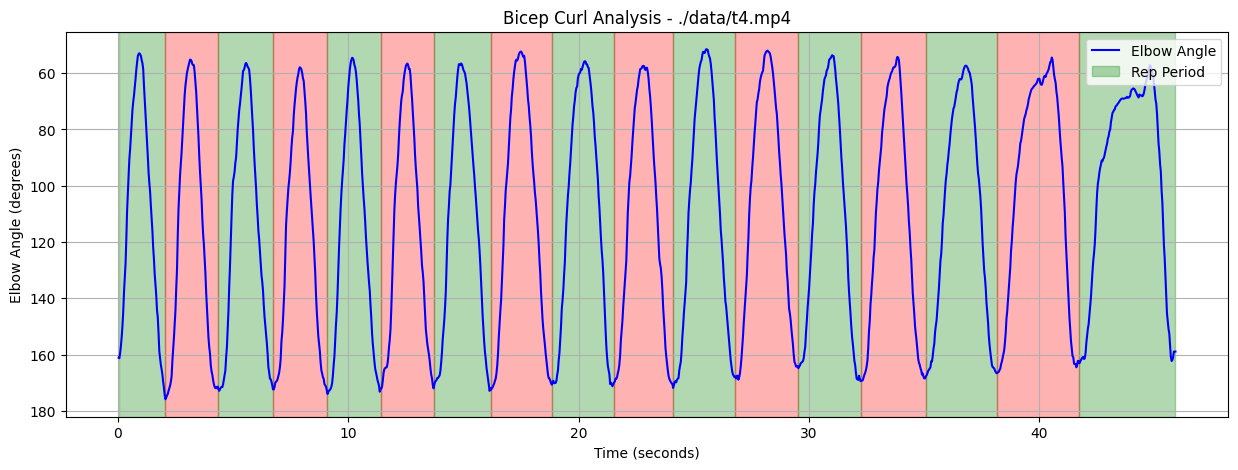

✅ Processed video saved as `./out/t4.mp4`

Total processing time: 33.70 seconds
Analyzing t5.mp4
Processing video frames...
Progress: 0.1%

I0000 00:00:1739719235.310250  776320 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739719235.401875  779435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739719235.416320  779440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 100.0%


Detected reps:
Rep 1: Start = 0.03s, End = 2.33s, Duration = 2.30s
Rep 2: Start = 2.33s, End = 4.70s, Duration = 2.37s
Rep 3: Start = 4.70s, End = 7.33s, Duration = 2.63s
Rep 4: Start = 7.33s, End = 10.23s, Duration = 2.90s
Rep 5: Start = 10.23s, End = 12.57s, Duration = 2.33s
Rep 6: Start = 12.57s, End = 14.97s, Duration = 2.40s
Rep 7: Start = 14.97s, End = 17.40s, Duration = 2.43s
Rep 8: Start = 17.40s, End = 19.77s, Duration = 2.37s
Rep 9: Start = 19.77s, End = 22.17s, Duration = 2.40s
Rep 10: Start = 22.17s, End = 24.67s, Duration = 2.50s
Rep 11: Start = 24.67s, End = 27.13s, Duration = 2.47s
Rep 12: Start = 27.13s, End = 29.53s, Duration = 2.40s
Rep 13: Start = 29.53s, End = 32.03s, Duration = 2.50s
Rep 14: Start = 32.03s, End = 34.50s, Duration = 2.47s
Rep 15: Start = 34.50s, End = 37.03s, Duration = 2.53s
Rep 16: Start = 37.03s, End = 39.97s, Duration = 2.93s
Rep 17: Start = 39.97s, End = 43.23s, Duration = 3.27s
Rep 18: Start = 43.23s, End = 46.60s, Duration 

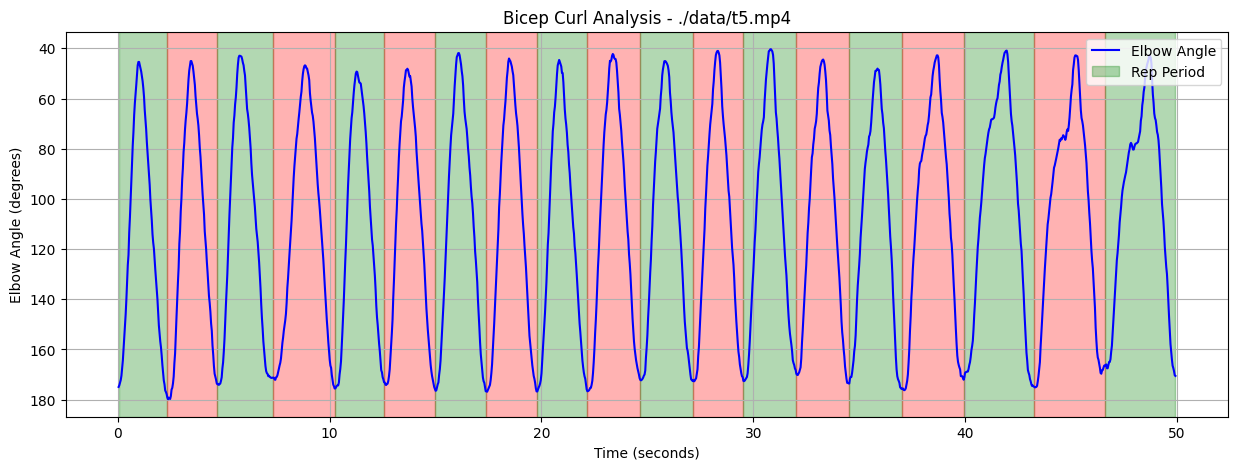

✅ Processed video saved as `./out/t5.mp4`

Total processing time: 36.49 seconds
Analyzing t6.mp4
Processing video frames...
Progress: 0.2%

I0000 00:00:1739719271.903972  776320 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1739719271.984677  779794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1739719271.997067  779794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Progress: 100.0%


Detected reps:
Rep 1: Start = 0.03s, End = 4.67s, Duration = 4.63s
Rep 2: Start = 4.67s, End = 8.43s, Duration = 3.77s
Rep 3: Start = 8.43s, End = 11.07s, Duration = 2.63s
Rep 4: Start = 11.07s, End = 13.87s, Duration = 2.80s
Rep 5: Start = 13.87s, End = 16.73s, Duration = 2.87s
Rep 6: Start = 16.73s, End = 19.57s, Duration = 2.83s
Rep 7: Start = 19.57s, End = 22.40s, Duration = 2.83s
Rep 8: Start = 22.40s, End = 25.13s, Duration = 2.73s
Rep 9: Start = 25.13s, End = 27.83s, Duration = 2.70s
Rep 10: Start = 27.83s, End = 30.47s, Duration = 2.63s
Rep 11: Start = 30.47s, End = 33.77s, Duration = 3.30s
Rep 12: Start = 33.77s, End = 36.90s, Duration = 3.13s
Rep 13: Start = 36.90s, End = 39.60s, Duration = 2.70s
Rep 14: Start = 39.60s, End = 42.27s, Duration = 2.67s
Rep 15: Start = 42.27s, End = 44.87s, Duration = 2.60s
Rep 16: Start = 44.87s, End = 48.13s, Duration = 3.27s
Rep 17: Start = 48.13s, End = 51.67s, Duration = 3.53s
Rep 18: Start = 51.67s, End = 54.73s, Duratio

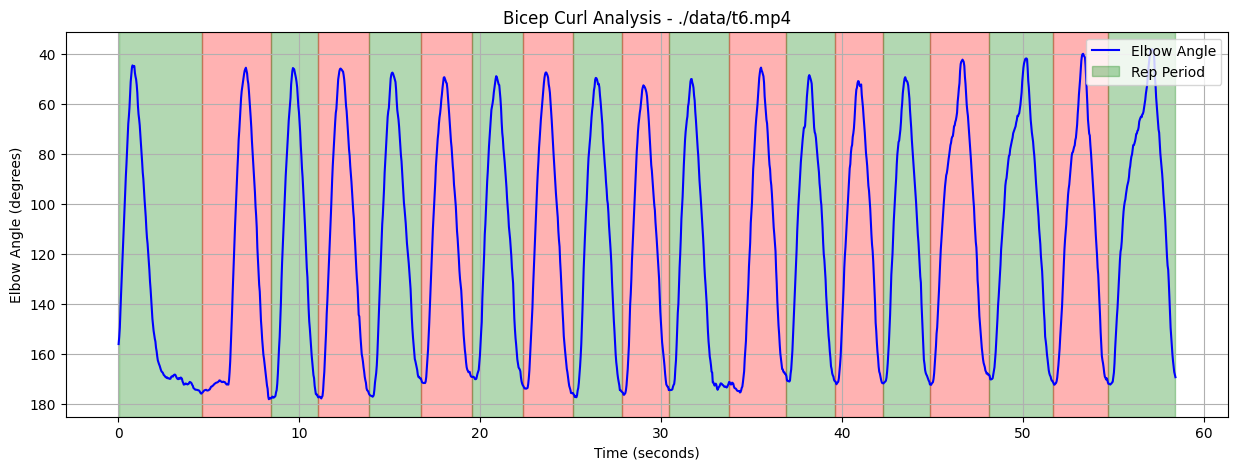

✅ Processed video saved as `./out/t6.mp4`

Total processing time: 41.89 seconds


In [5]:
files = os.listdir("./data")
print(files)

# for each file in ./data folder, run the analyze_bicep_curls function
for file in files:
    if file.endswith(".mp4") and "t" in file:
        print(f"Analyzing {file}")
        run_bicep_curl_analysis(f"./data/{file}", f"./out/{file}")

